In [1]:
spark

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 6, Finished, Available)

In [8]:
# read the data
workspace_default_storage_account = "group08astoragec0a5c9b39"
workspace_default_container = "azureml-blobstore-8f67895d-e507-48c5-8b8e-f003f0227b44"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)
df = spark.read.parquet((f"{workspace_wasbs_base_url}<PATH-TO-READ/WRITE>"))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 13, Finished, Available)

In [4]:
unique_controversiality = df.select("controversiality").distinct()

unique_controversiality.show()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 9, Finished, Available)

+----------------+
|controversiality|
+----------------+
|               0|
|               1|
+----------------+



Because 'controversiality' only contain two values, hence LogisticRegression is chosen. 

In [9]:
football_teams_subreddits = [
    "chelseafc", "reddevils", "gunners", "liverpoolfc", "coys", "mcfc", "barca",
    "realmadrid", "acmilan", "juve", "asroma", "fcbayern", "borussiadortmund",
    "schalke04", "atletico", "psg", "ajaxamsterdam", "celticfc"
]

#filter the DataFrame
club_subreddits = df.filter(df.subreddit.isin(football_teams_subreddits))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 14, Finished, Available)

In [10]:
filter_club_subreddits = club_subreddits.select("body", "controversiality", "score")

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 15, Finished, Available)

In [11]:
filter_club_subreddits.show()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 16, Finished, Available)

+--------------------+----------------+-----+
|                body|controversiality|score|
+--------------------+----------------+-----+
| Mudryk is injured??|               0|    1|
|No he is a suppor...|               0|    7|
|Remember when TT ...|               1|   -3|
|Feel like everyon...|               0|    8|
|Yeah for like 20 ...|               0|    2|
|Naaah mate he's h...|               0|    1|
|Hopefully that bo...|               0|    1|
|        30 minutes..|               0|    2|
|Entirely possible...|               0|   11|
|I hate Gary Nevil...|               0|    5|
|            so brave|               0|    1|
|  They really aren't|               0|    1|
| For 25’ 2 weeks ago|               0|    2|
|Why? It was weird...|               0|    1|
|I'll buy one just...|               0|    1|
|Why did we have t...|               0|    3|
|… will fail? \n\n...|               0|    3|
|Why did mudryk co...|               0|    3|
|Well said, so sic...|            

In [12]:
filter_club_subreddits.cache()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 17, Finished, Available)

DataFrame[body: string, controversiality: bigint, score: bigint]

### Data Pre-processing, and Build a Pipeline

In [13]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 18, Finished, Available)

In [15]:
tokenizer = Tokenizer(inputCol="body", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="textFeatures")
assembler = VectorAssembler(inputCols=["textFeatures", "score"], outputCol="features")

#model with different hyperparameters
lr1 = LogisticRegression(featuresCol="features", labelCol="controversiality", regParam=0.1, maxIter=10)
lr2 = LogisticRegression(featuresCol="features", labelCol="controversiality", regParam=0.01, maxIter=20)

#define pipelines
pipeline1 = Pipeline(stages=[tokenizer, cv, idf, assembler, lr1])
pipeline2 = Pipeline(stages=[tokenizer, cv, idf, assembler, lr2])

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 20, Finished, Available)

In [16]:
#split Data
train_data, test_data = filter_club_subreddits.randomSplit([0.7, 0.3], seed=24)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 21, Finished, Available)

In [17]:
model1 = pipeline1.fit(train_data)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 22, Finished, Available)

### Model 1: Prediction and Evaluation

In [18]:
predictions1 = model1.transform(test_data)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 23, Finished, Available)

In [19]:
evaluator = BinaryClassificationEvaluator(labelCol="controversiality", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 24, Finished, Available)

In [21]:
roc_auc1 = evaluator.evaluate(predictions1)
multi_evaluator = MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction")
accuracy1 = multi_evaluator.evaluate(predictions1, {multi_evaluator.metricName: "accuracy"})
f1_score1 = multi_evaluator.evaluate(predictions1, {multi_evaluator.metricName: "f1"})

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 26, Finished, Available)

In [37]:
print("ROC AUC:", roc_auc1)
print("Accuracy:", accuracy1)
print("F1 Score:", f1_score1)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 42, Finished, Available)

ROC AUC: 0.6542570807697206
Accuracy: 0.960308570734374
F1 Score: 0.9425857568809598


In [31]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

#convert to pandas DataFrame
pandas_df_1 = predictions1.select('prediction', 'controversiality').toPandas()

#calculate confusion matrix
confusion_matrix_pandas_1 = confusion_matrix(pandas_df_1['controversiality'], pandas_df_1['prediction'])
print("Confusion Matrix using Pandas:")
print(confusion_matrix_pandas_1)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 36, Finished, Available)

Confusion Matrix using Pandas:
[[395152    642]
 [ 15694     87]]


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 66, Finished, Available)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 65, Finished, Available)

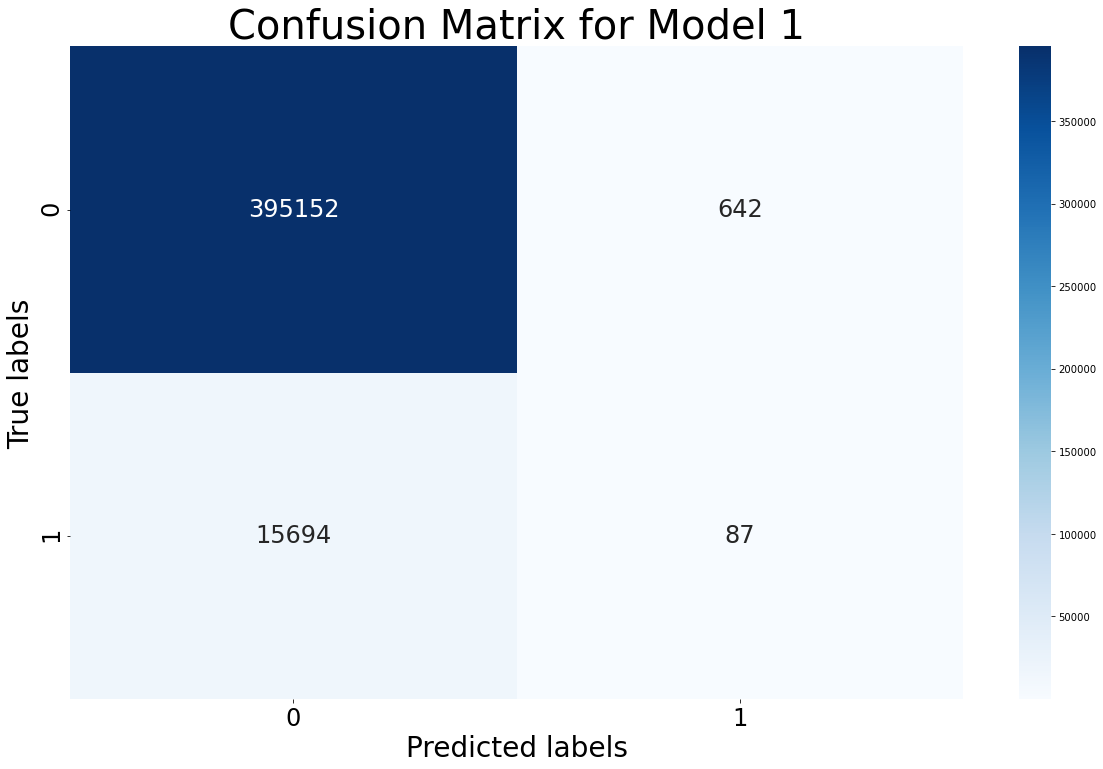

In [60]:
plt.figure(figsize=(20, 12))
sns.heatmap(confusion_matrix_pandas_1, annot=True, fmt='g', cmap='Blues', annot_kws={"fontsize": 24})
plt.title('Confusion Matrix for Model 1', fontsize=40) 
plt.xlabel('Predicted labels', fontsize=28) 
plt.ylabel('True labels', fontsize=28)
plt.tick_params(axis='both', labelsize=24)

#save the plot
datapath = 'Users/jy736/fall-2023-reddit-project-team-08/data'
plt.savefig(f'{datapath}/plots/model_1_cm.png', bbox_inches='tight', dpi=300)

#display the plot
plt.show()

### Model 2: Prediction and Evaluation

In [32]:
model2 = pipeline2.fit(train_data)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 37, Finished, Available)

In [33]:
predictions2 = model2.transform(test_data)
roc_auc2 = evaluator.evaluate(predictions2)
multi_evaluator = MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction")
accuracy2 = multi_evaluator.evaluate(predictions2, {multi_evaluator.metricName: "accuracy"})
f1_score2 = multi_evaluator.evaluate(predictions2, {multi_evaluator.metricName: "f1"})

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 38, Finished, Available)

In [36]:
print("ROC AUC:", roc_auc2)
print("Accuracy:", accuracy2)
print("F1 Score:", f1_score2)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 41, Finished, Available)

ROC AUC: 0.6212710494554697
Accuracy: 0.9552693919698718
F1 Score: 0.9411906356473216


In [35]:
#convert to pandas DataFrame
pandas_df_2 = predictions2.select('prediction', 'controversiality').toPandas()

#calculate confusion matrix
confusion_matrix_pandas_2 = confusion_matrix(pandas_df_2['controversiality'], pandas_df_2['prediction'])
print("Confusion Matrix using Pandas:")
print(confusion_matrix_pandas_2)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 40, Finished, Available)

Confusion Matrix using Pandas:
[[392776   3018]
 [ 15392    389]]


StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 67, Finished, Available)

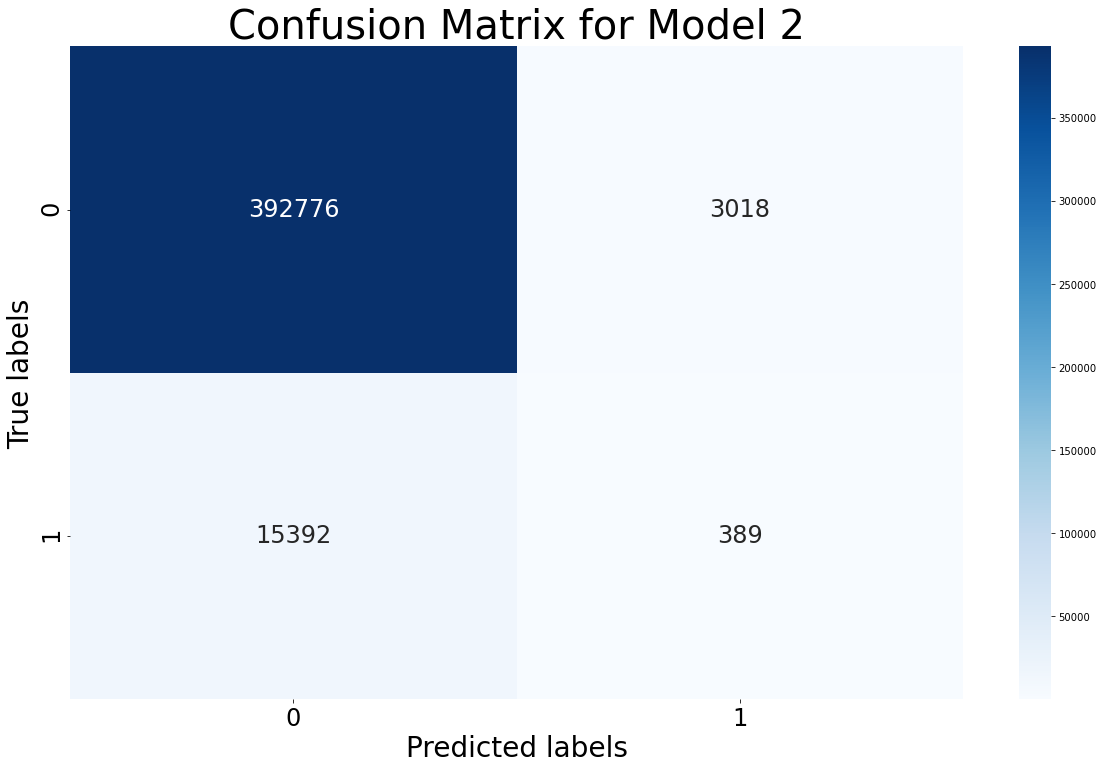

In [62]:
plt.figure(figsize=(20, 12))
sns.heatmap(confusion_matrix_pandas_2, annot=True, fmt='g', cmap='Blues', annot_kws={"fontsize": 24})
plt.title('Confusion Matrix for Model 2', fontsize=40) 
plt.xlabel('Predicted labels', fontsize=28) 
plt.ylabel('True labels', fontsize=28)
plt.tick_params(axis='both', labelsize=24)

#save the plot
datapath = 'Users/jy736/fall-2023-reddit-project-team-08/data'
plt.savefig(f'{datapath}/plots/model_2_cm.png', bbox_inches='tight', dpi=300)

#display the plot
plt.show()

#### Build accuracy matrix

In [63]:
accuracy_summary = {
    "Model 1": [roc_auc1, accuracy1, f1_score1],
    "Model 2": [roc_auc2, accuracy2, f1_score2]
}

# create a df from the dictionary
accuracy_table = pd.DataFrame(accuracy_summary, index=["ROC AUC", "Accuracy", "F1 Score"])

#show the df
print(accuracy_table)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 68, Finished, Available)

           Model 1   Model 2
ROC AUC   0.654257  0.621271
Accuracy  0.960309  0.955269
F1 Score  0.942586  0.941191


In [64]:
accuracy_table.to_csv('Users/jy736/fall-2023-reddit-project-team-08/data/csv/model_metrics.csv')

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 69, Finished, Available)

### Export the model 1 that has the highest accuracy and import it.

In [43]:
model_path = 'Users/jy736/fall-2023-reddit-project-team-08/code/model1'
model1.write().overwrite().save(model_path)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 48, Finished, Available)

In [44]:
from pyspark.ml import PipelineModel

#load the model
loaded_model = PipelineModel.load(model_path)

#use the loaded model to make predictions
predictions = loaded_model.transform(test_data) 

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 49, Finished, Available)

In [46]:
roc_auc_load = evaluator.evaluate(predictions)
multi_evaluator = MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction")
accuracy_load = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
f1_score_load = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 51, Finished, Available)

In [47]:
print("ROC AUC:", roc_auc_load)
print("Accuracy:", accuracy_load)
print("F1 Score:", f1_score_load)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 52, Finished, Available)

ROC AUC: 0.6542668810825406
Accuracy: 0.960308570734374
F1 Score: 0.9425857568809598


In [48]:
#convert to pandas DataFrame
pandas_df_load = predictions.select('prediction', 'controversiality').toPandas()

#calculate confusion matrix
confusion_matrix_pandas_load = confusion_matrix(pandas_df_load['controversiality'], pandas_df_load['prediction'])
print("Confusion Matrix using Pandas:")
print(confusion_matrix_pandas_load)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 49, 53, Finished, Available)

Confusion Matrix using Pandas:
[[395152    642]
 [ 15694     87]]
